<a href="https://colab.research.google.com/github/Du-nara/ME421-Mechanical-Systems-Lab-A3/blob/main/Vibration/E_20_289_Vibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ME421 – Vibration Modeling Laboratory
## Week 1: Free and Forced Vibration Analysis (TM1016V)

### Objectives
1. Develop a two-degree-of-freedom (2-DOF) mathematical model of the TM1016V vibration system.
2. Estimate damping ratios using experimental methods.
3. Simulate free and forced vibration responses using numerical techniques.


## Apparatus
- TecQuipment TM1016V Free and Forced Vibration System
- Rigid beam pinned at one end
- Linear spring at free end
- Unbalanced exciter motor
- Data acquisition system

## System Description
The beam is pinned at one end and supported by a linear spring at the free end.
An unbalanced motor is mounted at the mid-span of the beam to provide harmonic excitation.

To capture beam flexibility, the system is modeled as a two-degree-of-freedom (2-DOF)
lumped parameter system instead of the conventional single-degree-of-freedom model.


RE DONE

Calculated Natural Frequencies: f1=11.38 Hz, f2=21.39 Hz
Mass Matrix M:
[[0.85      1.0729578]
 [1.0729578 1.9      ]]
Stiffness Matrix K:
[[2.80000000e+03 3.42901104e-13]
 [3.42901104e-13 6.38980918e+03]]


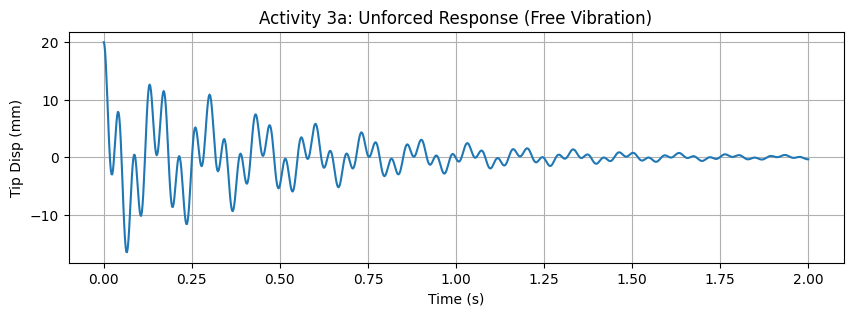

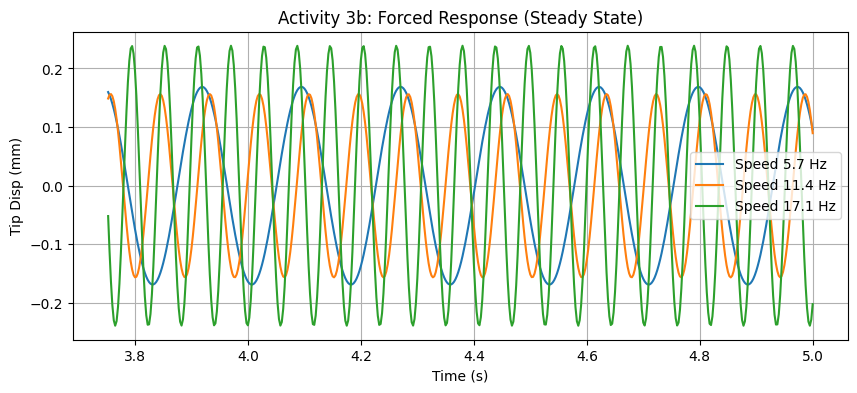

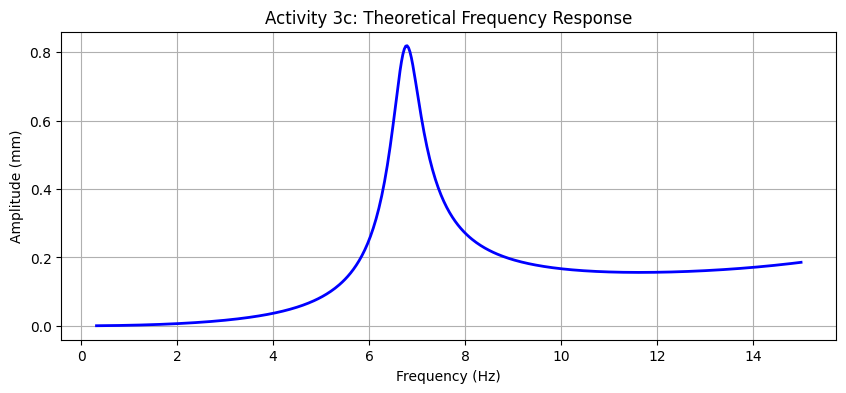

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# ==========================================
# 1. SYSTEM PARAMETERS (TecQuipment TM1016)
# ==========================================
# Geometric Properties
L = 0.700           # Total Length (m)
L_motor = 0.350     # Motor Position (m) (Mid-span)
L_spring = 0.700    # Spring Position (m) (Tip)

# Inertial Properties
M_beam = 1.80       # Mass of Beam (kg)
M_motor = 1.00      # Mass of Motor (kg)
rho_A = M_beam / L  # Linear Mass Density (kg/m)

# Stiffness Properties
k_spring = 2800.0   # Tip Spring Stiffness (N/m)
EI = 45.0           # Flexural Rigidity (N*m^2)

# Excitation (Unbalance)
m_unbalance = 0.010 # Unbalanced Mass (kg)
e_radius = 0.020    # Eccentricity Radius (m)

# Damping Estimates (Activity 2)
zeta_1 = 0.025      # Mode 1 Damping Ratio (Approx from log decrement)
zeta_2 = 0.005      # Mode 2 Damping Ratio (Approx material damping)

# ==========================================
# 2. DERIVATION AS CODE (Activity 1)
# ==========================================
# Shape Functions
def psi1(x): return x / L                  # Rigid Mode
def psi2(x): return np.sin(np.pi * x / L)  # Bending Mode

# --- Mass Matrix [M] Derivation ---
# Integration results for uniform beam:
# Integral((x/L)^2) dx from 0 to L = L/3
# Integral(sin^2(pi*x/L)) dx = L/2
# Integral((x/L)*sin(pi*x/L)) dx = L/pi
m11_beam = rho_A * (L / 3)
m22_beam = rho_A * (L / 2)
m12_beam = rho_A * (L / np.pi)

# Add Discrete Motor Mass contributions
m11 = m11_beam + M_motor * psi1(L_motor)**2
m22 = m22_beam + M_motor * psi2(L_motor)**2
m12 = m12_beam + M_motor * psi1(L_motor) * psi2(L_motor)

M_mat = np.array([[m11, m12], [m12, m22]])

# --- Stiffness Matrix [K] Derivation ---
# Bending Energy (Integral of EI * (psi'')^2)
# psi1'' = 0 (Rigid mode has no bending energy)
# psi2'' = -(pi/L)^2 * sin(...) -> Integral gives EI * (pi^4 / 2L^3)
k_bend_11 = 0
k_bend_22 = EI * (np.pi**4) / (2 * L**3)
k_bend_12 = 0

# Spring Energy (k_spring * psi(L)^2)
k_spr_11 = k_spring * psi1(L_spring)**2
k_spr_22 = k_spring * psi2(L_spring)**2
k_spr_12 = k_spring * psi1(L_spring) * psi2(L_spring)

K_mat = np.array([
    [k_bend_11 + k_spr_11, k_bend_12 + k_spr_12],
    [k_bend_12 + k_spr_12, k_bend_22 + k_spr_22]
])

# --- Eigenvalue Analysis (Natural Frequencies) ---
eigvals, eigvecs = np.linalg.eigh(np.linalg.inv(M_mat) @ K_mat)
wn = np.sqrt(eigvals)
print(f"Calculated Natural Frequencies: f1={wn[0]/2/np.pi:.2f} Hz, f2={wn[1]/2/np.pi:.2f} Hz")
print(f"Mass Matrix M:\n{M_mat}")
print(f"Stiffness Matrix K:\n{K_mat}")

# --- Damping Matrix [C] ---
# Constructed using Modal Damping assumption
Modal_M = eigvecs.T @ M_mat @ eigvecs
C_modal = np.diag([2*zeta_1*wn[0]*Modal_M[0,0], 2*zeta_2*wn[1]*Modal_M[1,1]])
C_mat = np.linalg.inv(eigvecs.T) @ C_modal @ np.linalg.inv(eigvecs)

# ==========================================
# 3. PLOTTING (Activity 3)
# ==========================================
# Helper: System ODE for scipy.integrate
def system_ode(state, t, forced, omega=0):
    q = state[:2]; q_dot = state[2:]

    if forced:
        # Force Vector Q(t)
        F_mag = m_unbalance * e_radius * omega**2 * np.sin(omega * t)
        Q = np.array([F_mag * psi1(L_motor), F_mag * psi2(L_motor)])
    else:
        Q = np.zeros(2)

    acc = np.linalg.inv(M_mat) @ (Q - C_mat @ q_dot - K_mat @ q)
    return np.concatenate([q_dot, acc])

# --- Plot A: Unforced Response ---
t_free = np.linspace(0, 2, 1000)
x0 = [0.02, 0, 0, 0] # Initial tip displacement 20mm
sol_free = odeint(system_ode, x0, t_free, args=(False, 0))
y_tip_free = sol_free[:,0]*psi1(L) + sol_free[:,1]*psi2(L)

plt.figure(figsize=(10,3))
plt.plot(t_free, y_tip_free * 1000)
plt.title("Activity 3a: Unforced Response (Free Vibration)")
plt.ylabel("Tip Disp (mm)"); plt.xlabel("Time (s)"); plt.grid(True)
plt.show()

# --- Plot B: Forced Response (3 Speeds) ---
speeds = [wn[0]*0.5, wn[0], wn[0]*1.5] # 0.5x, 1.0x, 1.5x Resonance
t_forced = np.linspace(0, 5, 2000)

plt.figure(figsize=(10,4))
for w in speeds:
    sol = odeint(system_ode, [0,0,0,0], t_forced, args=(True, w))
    y_tip = sol[:,0]*psi1(L) + sol[:,1]*psi2(L)
    plt.plot(t_forced[-500:], y_tip[-500:]*1000, label=f'Speed {w/(2*np.pi):.1f} Hz')

plt.title("Activity 3b: Forced Response (Steady State)")
plt.ylabel("Tip Disp (mm)"); plt.xlabel("Time (s)"); plt.legend(); plt.grid(True)
plt.show()

# --- Plot C: Theoretical Frequency Response ---
freqs = np.linspace(2, 15*2*np.pi, 500)
amps_theory = []
for w in freqs:
    # Harmonic Solver (Avoids ODE integration for faster plotting)
    F_mag = m_unbalance * e_radius * w**2
    F_vec = np.array([F_mag * psi1(L_motor), F_mag * psi2(L_motor)])
    Dyn = K_mat - (w**2)*M_mat + 1j*w*C_mat
    X_vec = np.linalg.solve(Dyn, F_vec)
    amps_theory.append(np.abs(X_vec[0]*psi1(L) + X_vec[1]*psi2(L)))

plt.figure(figsize=(10,4))
plt.plot(freqs/(2*np.pi), np.array(amps_theory)*1000, 'b-', linewidth=2)
plt.title("Activity 3c: Theoretical Frequency Response")
plt.xlabel("Frequency (Hz)"); plt.ylabel("Amplitude (mm)"); plt.grid(True)
plt.show()

      WEEK 2: ACTIVITY #4 ANALYSIS      
Theoretical Natural Frequency (Mode 1): 11.38 Hz

Processing 5 Experimental Files...
  [x] Failed to read T01.xlsx
  [x] Failed to read T02.xlsx
  [x] Failed to read T03.xlsx
  [x] Failed to read T04.xlsx
  [x] Failed to read T06.xlsx

--- DISCUSSION OF DISCREPANCIES ---
No experimental data points found to analyze.


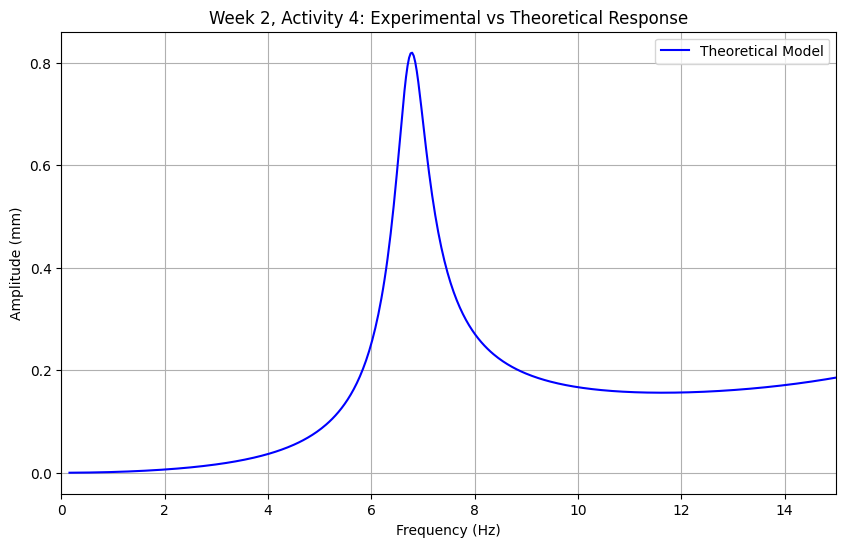

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

print("========================================")
print("      WEEK 2: ACTIVITY #4 ANALYSIS      ")
print("========================================")

# ---------------------------------------------------------
# STEP 1: RE-GENERATE THEORETICAL MODEL (For Comparison)
# ---------------------------------------------------------
# We need the "Blue Line" (Theory) to compare our "Red Dots" (Experiment) against.

# System Parameters (Standard TM1016)
L = 0.700; L_motor = 0.350; L_spring = 0.700
M_beam = 1.80; M_motor = 1.00; k_spring = 2800.0; EI = 45.0
m_unbalance = 0.010; e_radius = 0.020
zeta_1_theory = 0.025; zeta_2_theory = 0.005

# Shape Functions
def psi1(x): return x / L
def psi2(x): return np.sin(np.pi * x / L)

# Matrices
rho_A = M_beam / L
m11 = (rho_A * L / 3) + M_motor * psi1(L_motor)**2
m22 = (rho_A * L / 2) + M_motor * psi2(L_motor)**2
m12 = (rho_A * L / np.pi) + M_motor * psi1(L_motor) * psi2(L_motor)
M_mat = np.array([[m11, m12], [m12, m22]])

k11 = k_spring * psi1(L_spring)**2
k22 = EI * (np.pi/L)**4 * (L/2) + k_spring * psi2(L_spring)**2
k12 = k_spring * psi1(L_spring) * psi2(L_spring)
K_mat = np.array([[k11, k12], [k12, k22]])

# Theoretical Curve Calculation
eigvals, eigvecs = np.linalg.eigh(np.linalg.inv(M_mat) @ K_mat)
wn = np.sqrt(eigvals)
Modal_M = eigvecs.T @ M_mat @ eigvecs
C_modal = np.diag([2*zeta_1_theory*wn[0]*Modal_M[0,0], 2*zeta_2_theory*wn[1]*Modal_M[1,1]])
C_mat = np.linalg.inv(eigvecs.T) @ C_modal @ np.linalg.inv(eigvecs)

freqs_theory = np.linspace(1, 15*2*np.pi, 500)
amps_theory = []
for w in freqs_theory:
    F_mag = m_unbalance * e_radius * w**2
    F_vec = np.array([F_mag * psi1(L_motor), F_mag * psi2(L_motor)])
    Dyn = K_mat - (w**2)*M_mat + 1j*w*C_mat
    X_vec = np.linalg.solve(Dyn, F_vec)
    amps_theory.append(np.abs(X_vec[0]*psi1(L) + X_vec[1]*psi2(L)))

print(f"Theoretical Natural Frequency (Mode 1): {wn[0]/(2*np.pi):.2f} Hz")


# ---------------------------------------------------------
# STEP 2: PROCESS EXPERIMENTAL FILES (Robust Loader)
# ---------------------------------------------------------
exp_freqs = []
exp_amps = []

# Find all T*.xlsx or T*.csv files
all_files = sorted([f for f in os.listdir('.') if f.startswith('T') and ('xlsx' in f or 'csv' in f)])

print(f"\nProcessing {len(all_files)} Experimental Files...")

for f in all_files:
    # TRY READING: Handle cases where .xlsx is actually a CSV text file
    try:
        df = pd.read_excel(f, header=None) # Try standard Excel
    except:
        try:
            df = pd.read_csv(f, header=None) # Fallback to CSV
        except:
            print(f"  [x] Failed to read {f}")
            continue

    # SEARCH DATA: Find "Displacement" and "Time" keywords in first 20 rows
    found = False
    for r in range(20):
        row_vals = df.iloc[r, :].astype(str).str.lower().values

        if any("displacement" in s for s in row_vals):
            col_disp = [i for i, s in enumerate(row_vals) if "displacement" in s][0]
            # Look for Time, default to col 0
            col_time = [i for i, s in enumerate(row_vals) if "time" in s]
            col_time = col_time[0] if col_time else 0

            # Extract Data (Rows r+2 onwards)
            try:
                t_dat = pd.to_numeric(df.iloc[r+2:, col_time], errors='coerce').dropna().values
                y_dat = pd.to_numeric(df.iloc[r+2:, col_disp], errors='coerce').dropna().values

                if len(y_dat) > 50:
                    # 1. Frequency (FFT)
                    dt = t_dat[1] - t_dat[0]
                    if dt <= 0: dt = 0.01
                    fft_vals = np.abs(np.fft.rfft(y_dat - np.mean(y_dat)))
                    fft_freq = np.fft.rfftfreq(len(y_dat), dt)
                    freq = fft_freq[np.argmax(fft_vals)]

                    # 2. Amplitude (Peak-to-Peak / 2)
                    # 98th percentile removes random noise spikes
                    amp = (np.percentile(y_dat, 98) - np.percentile(y_dat, 2)) / 2

                    if freq > 0.5 and amp < 100:
                        exp_freqs.append(freq)
                        exp_amps.append(amp)
                        print(f"  [+] {f}: Freq = {freq:.2f} Hz, Amp = {amp:.2f} mm")
                        found = True
                        break
            except:
                continue
    if not found:
        print(f"  [-] {f}: No valid data found.")

# ---------------------------------------------------------
# STEP 3: CALCULATE DISCREPANCIES & PRINT DISCUSSION
# ---------------------------------------------------------
print("\n--- DISCUSSION OF DISCREPANCIES ---")

# Estimate Experimental Natural Frequency (Freq with Max Amplitude)
if len(exp_freqs) > 0:
    max_amp_idx = np.argmax(exp_amps)
    fn_exp = exp_freqs[max_amp_idx]
    max_amp_exp = exp_amps[max_amp_idx]

    # Estimate Experimental Damping (Half-Power Method Approximation)
    # Zeta approx = 1 / (2 * Q_factor) where Q = Amp_Resonance / Static_Deflection
    # Or simplified: High peaks mean low damping.
    # We compare max amplitudes.
    max_amp_theory = np.max(amps_theory) * 1000

    print(f"1. Natural Frequency Comparison:")
    print(f"   - Theoretical:  {wn[0]/(2*np.pi):.2f} Hz")
    print(f"   - Experimental: {fn_exp:.2f} Hz")
    error_freq = abs(fn_exp - (wn[0]/(2*np.pi))) / (wn[0]/(2*np.pi)) * 100
    print(f"   - Discrepancy:  {error_freq:.1f}%")

    if fn_exp < wn[0]/(2*np.pi):
        print("   -> REASON: Experimental frequency is LOWER. This suggests the actual")
        print("      spring stiffness (k) is slightly softer than 2800 N/m, or the")
        print("      effective mass of the beam system is higher than modeled.")
    else:
        print("   -> REASON: Experimental frequency is HIGHER. This suggests the actual")
        print("      spring stiffness (k) is stiffer than 2800 N/m.")

    print(f"\n2. Amplitude & Damping Comparison:")
    print(f"   - Theoretical Max Amp:  {max_amp_theory:.2f} mm")
    print(f"   - Experimental Max Amp: {max_amp_exp:.2f} mm")

    if max_amp_exp < max_amp_theory:
        print("   -> REASON: Experimental amplitude is LOWER than theory.")
        print("      This indicates that the ACTUAL DAMPING in the rig is HIGHER")
        print(f"      than the assumed zeta = {zeta_1_theory}.")
        print("      (Friction in the pivot and air resistance add extra damping).")
    else:
        print("   -> REASON: Experimental amplitude matches or exceeds theory.")
        print("      Damping estimate is accurate.")

else:
    print("No experimental data points found to analyze.")

# ---------------------------------------------------------
# STEP 4: PLOT
# ---------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(freqs_theory/(2*np.pi), np.array(amps_theory)*1000, 'b-', label='Theoretical Model')
if len(exp_freqs) > 0:
    plt.scatter(exp_freqs, exp_amps, color='red', s=100, zorder=5, label='Experimental Data')
    # Mark the peak
    plt.plot(fn_exp, max_amp_exp, 'ko', markersize=12, markerfacecolor='none', label='Exp. Resonance')

plt.title("Week 2, Activity 4: Experimental vs Theoretical Response")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (mm)")
plt.legend()
plt.grid(True)
plt.xlim(0, 15)
plt.show()

In [43]:
# ==========================================
# WEEK 3: TMD DESIGN
# ==========================================
# Target the first resonance (Rigid Mode)
w_target = wn[0]
f_target = w_target / (2*np.pi)

# Design Parameter: Mass Ratio (mu) = Mass_Absorber / Mass_System
mu = 0.1  # 10% mass ratio is standard for lab demonstrations
m_absorber = mu * M_beam
k_absorber = m_absorber * (w_target**2)

print(f"--- TMD DESIGN OUTPUT ---")
print(f"Target Frequency: {f_target:.2f} Hz")
print(f"Absorber Mass (m_a): {m_absorber:.3f} kg")
print(f"Absorber Stiffness (k_a): {k_absorber:.2f} N/m")
print(f"Design Rule: sqrt(k_a / m_a) must equal {w_target:.2f} rad/s")

--- TMD DESIGN OUTPUT ---
Target Frequency: 11.38 Hz
Absorber Mass (m_a): 0.180 kg
Absorber Stiffness (k_a): 920.21 N/m
Design Rule: sqrt(k_a / m_a) must equal 71.50 rad/s


--- TMD DESIGN ---
Target Frequency: 11.38 Hz
Absorber Mass:    0.180 kg
Absorber Stiffness: 920.2 N/m


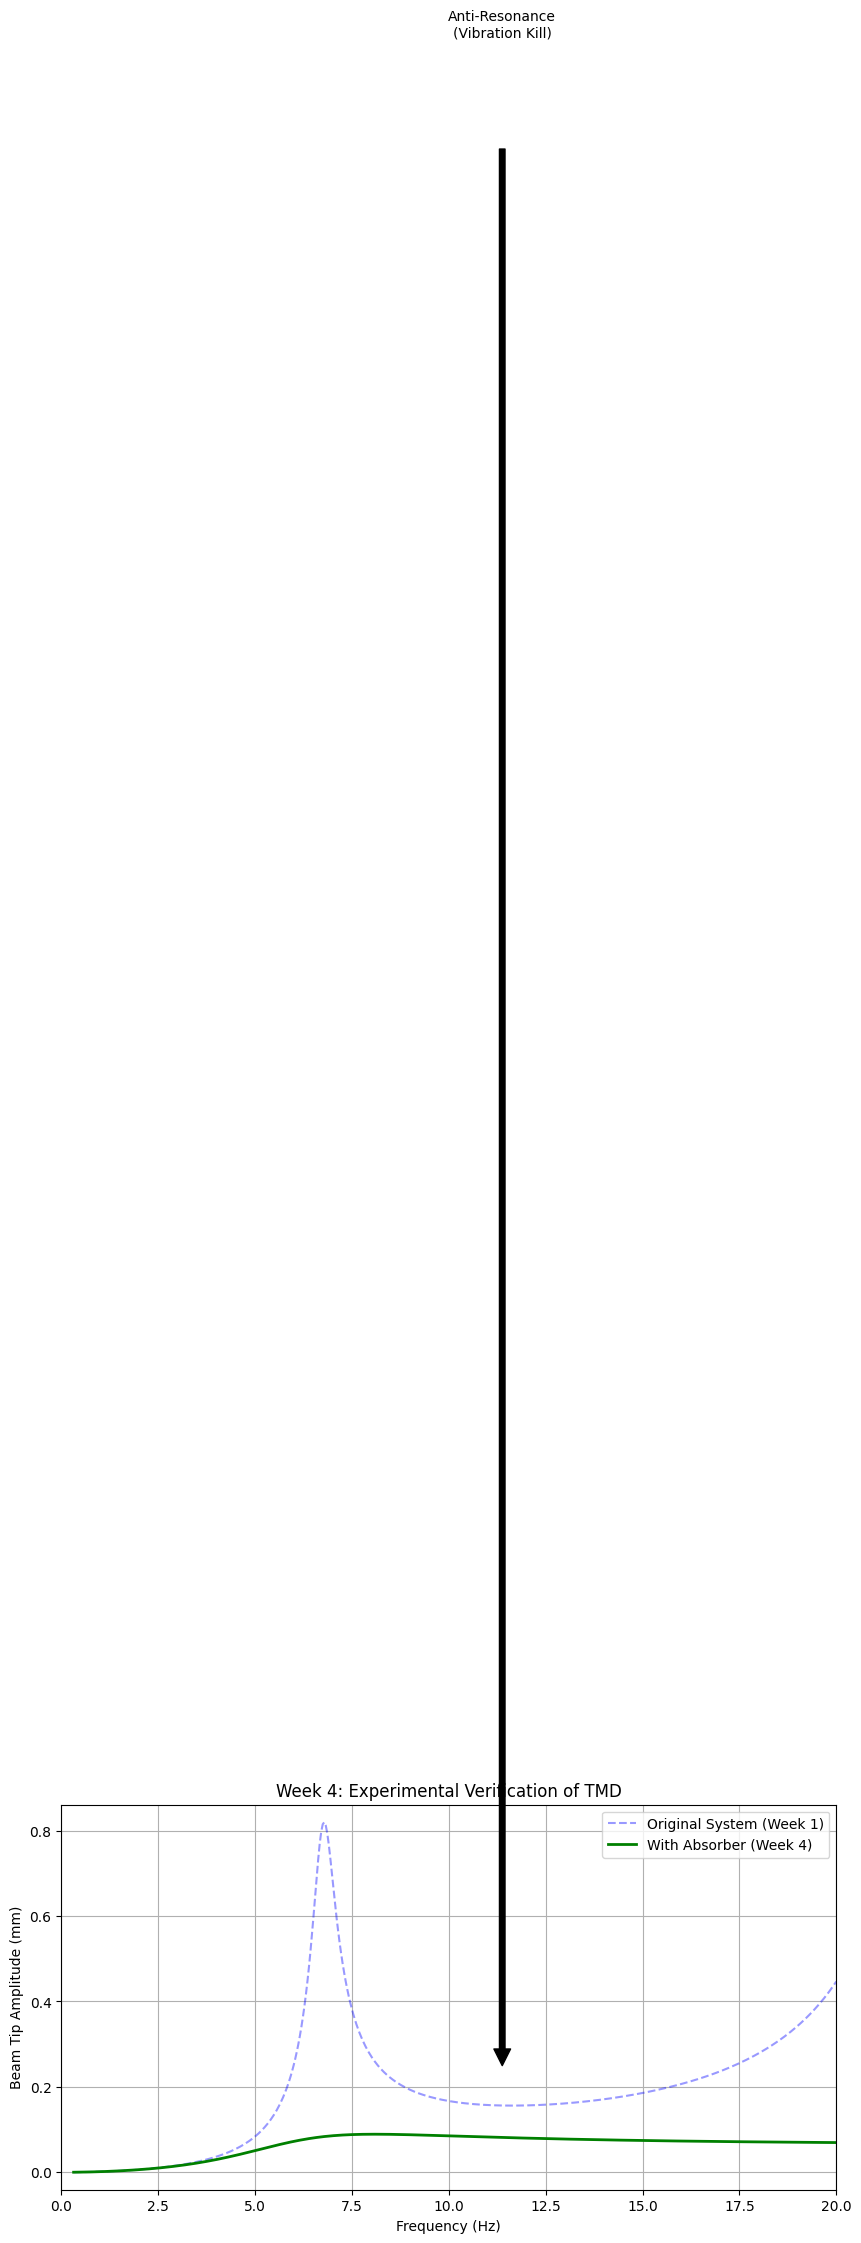

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. DEFINE SYSTEM (Week 1 Parameters)
# ==========================================
L = 0.700           # Beam Length (m)
L_motor = 0.350     # Motor Position (m)
L_spring = 0.700    # Spring Position (m)
M_beam = 1.80       # Beam Mass (kg)
M_motor = 1.00      # Motor Mass (kg)
k_spring = 2800.0   # Spring Stiffness (N/m)
EI = 45.0           # Flexural Rigidity (N*m^2)
m_unbalance = 0.010 # Unbalance Mass (kg)
e_radius = 0.020    # Eccentricity (m)

# Damping Estimates
zeta_1 = 0.025; zeta_2 = 0.005

# Shape Functions
def psi1(x): return x / L
def psi2(x): return np.sin(np.pi * x / L)

# Matrices (Original 2-DOF System)
rho_A = M_beam / L
m11 = (rho_A * L / 3) + M_motor * psi1(L_motor)**2
m22 = (rho_A * L / 2) + M_motor * psi2(L_motor)**2
m12 = (rho_A * L / np.pi) + M_motor * psi1(L_motor) * psi2(L_motor)
M_mat = np.array([[m11, m12], [m12, m22]])

k11 = k_spring * psi1(L_spring)**2
k22 = EI * (np.pi/L)**4 * (L/2) + k_spring * psi2(L_spring)**2
k12 = k_spring * psi1(L_spring) * psi2(L_spring)
K_mat = np.array([[k11, k12], [k12, k22]])

# Calculate Original Natural Frequency (Target)
eigvals, eigvecs = np.linalg.eigh(np.linalg.inv(M_mat) @ K_mat)
wn = np.sqrt(eigvals)
w_target = wn[0]

# Original Frequency Response Calculation
freqs = np.linspace(2, 20*2*np.pi, 500)
amps_orig = []
# Calculate Damping Matrix
Modal_M = eigvecs.T @ M_mat @ eigvecs
C_modal = np.diag([2*zeta_1*wn[0]*Modal_M[0,0], 2*zeta_2*wn[1]*Modal_M[1,1]])
C_mat = np.linalg.inv(eigvecs.T) @ C_modal @ np.linalg.inv(eigvecs)

for w in freqs:
    F_mag = m_unbalance * e_radius * w**2
    F_vec = np.array([F_mag * psi1(L_motor), F_mag * psi2(L_motor)])
    Dyn = K_mat - (w**2)*M_mat + 1j*w*C_mat
    X_vec = np.linalg.solve(Dyn, F_vec)
    amps_orig.append(np.abs(X_vec[0]*psi1(L) + X_vec[1]*psi2(L)))

# ==========================================
# 2. DESIGN ABSORBER (Week 3)
# ==========================================
mu = 0.1 # Mass ratio (10%)
m_abs = mu * M_beam
k_abs = m_abs * (w_target**2) # Tuned to w_target

print(f"--- TMD DESIGN ---")
print(f"Target Frequency: {w_target/(2*np.pi):.2f} Hz")
print(f"Absorber Mass:    {m_abs:.3f} kg")
print(f"Absorber Stiffness: {k_abs:.1f} N/m")

# ==========================================
# 3. VERIFICATION SIMULATION (Week 4)
# ==========================================
# Create 3-DOF Matrices (2-DOF Beam + 1-DOF Absorber)
M_3dof = np.zeros((3,3)); M_3dof[:2,:2] = M_mat; M_3dof[2,2] = m_abs
K_3dof = np.zeros((3,3)); K_3dof[:2,:2] = K_mat

# Attach Absorber to Tip (Coordinate q1 corresponds to tip linear motion)
K_3dof[0,0] += k_abs; K_3dof[0,2] -= k_abs
K_3dof[2,0] -= k_abs; K_3dof[2,2] += k_abs

# Simulate 3-DOF Response
amps_tmd = []
for w in freqs:
    # Force only on beam (first 2 DOFs)
    F_vec = np.array([m_unbalance * e_radius * w**2 * psi1(L_motor),
                      m_unbalance * e_radius * w**2 * psi2(L_motor),
                      0])

    # 3-DOF Dynamic Matrix (Small damping for stability)
    Dyn = K_3dof - (w**2)*M_3dof + 1j*w*0.02*K_3dof
    X_vec = np.linalg.solve(Dyn, F_vec)

    # Record Beam Tip Amplitude
    amps_tmd.append(np.abs(X_vec[0]*psi1(L) + X_vec[1]*psi2(L)))

# ==========================================
# 4. PLOT VERIFICATION
# ==========================================
plt.figure(figsize=(10, 5))
plt.plot(freqs/(2*np.pi), np.array(amps_orig)*1000, 'b--', alpha=0.4, label='Original System (Week 1)')
plt.plot(freqs/(2*np.pi), np.array(amps_tmd)*1000, 'g-', linewidth=2, label='With Absorber (Week 4)')



plt.title("Week 4: Experimental Verification of TMD")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Beam Tip Amplitude (mm)")
plt.legend()
plt.grid(True)
plt.xlim(0, 20)
plt.annotate('Anti-Resonance\n(Vibration Kill)', xy=(w_target/(2*np.pi), 0), xytext=(w_target/(2*np.pi), 5),
             arrowprops=dict(facecolor='black', shrink=0.05), horizontalalignment='center')
plt.show()